In [1]:
# Basic imports
import pandas as pd
import numpy as np
import sqlalchemy as sa
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

In [5]:
df = pd.read_csv('raw_data/processed_data_2024.csv')
x = df[df['MatBucket']=='21+']
df = x[x['PP_qty'].notna()]
df['pmt_arr'] = df.apply(lambda row: np.array(np.repeat([0],300)), axis=1 )

This line is going to insert a 1 in the month from origination where the loan paid off

In [6]:
df['pmt_arr'] = df.apply(lambda row: np.put(row['pmt_arr'], row['PP_qty'], 1) or row['pmt_arr'], axis=1)



In [9]:
df['transition_month']= df['pmt_arr'].apply(lambda arr: np.argmax(arr) or len(arr))
# Calculate the count of loans transitioning by month
transition_counts = df['transition_month'].value_counts().sort_index()

# Calculate the cumulative proportion of loans paid off by each month
cumulative_proportion = transition_counts.cumsum() / len(df)


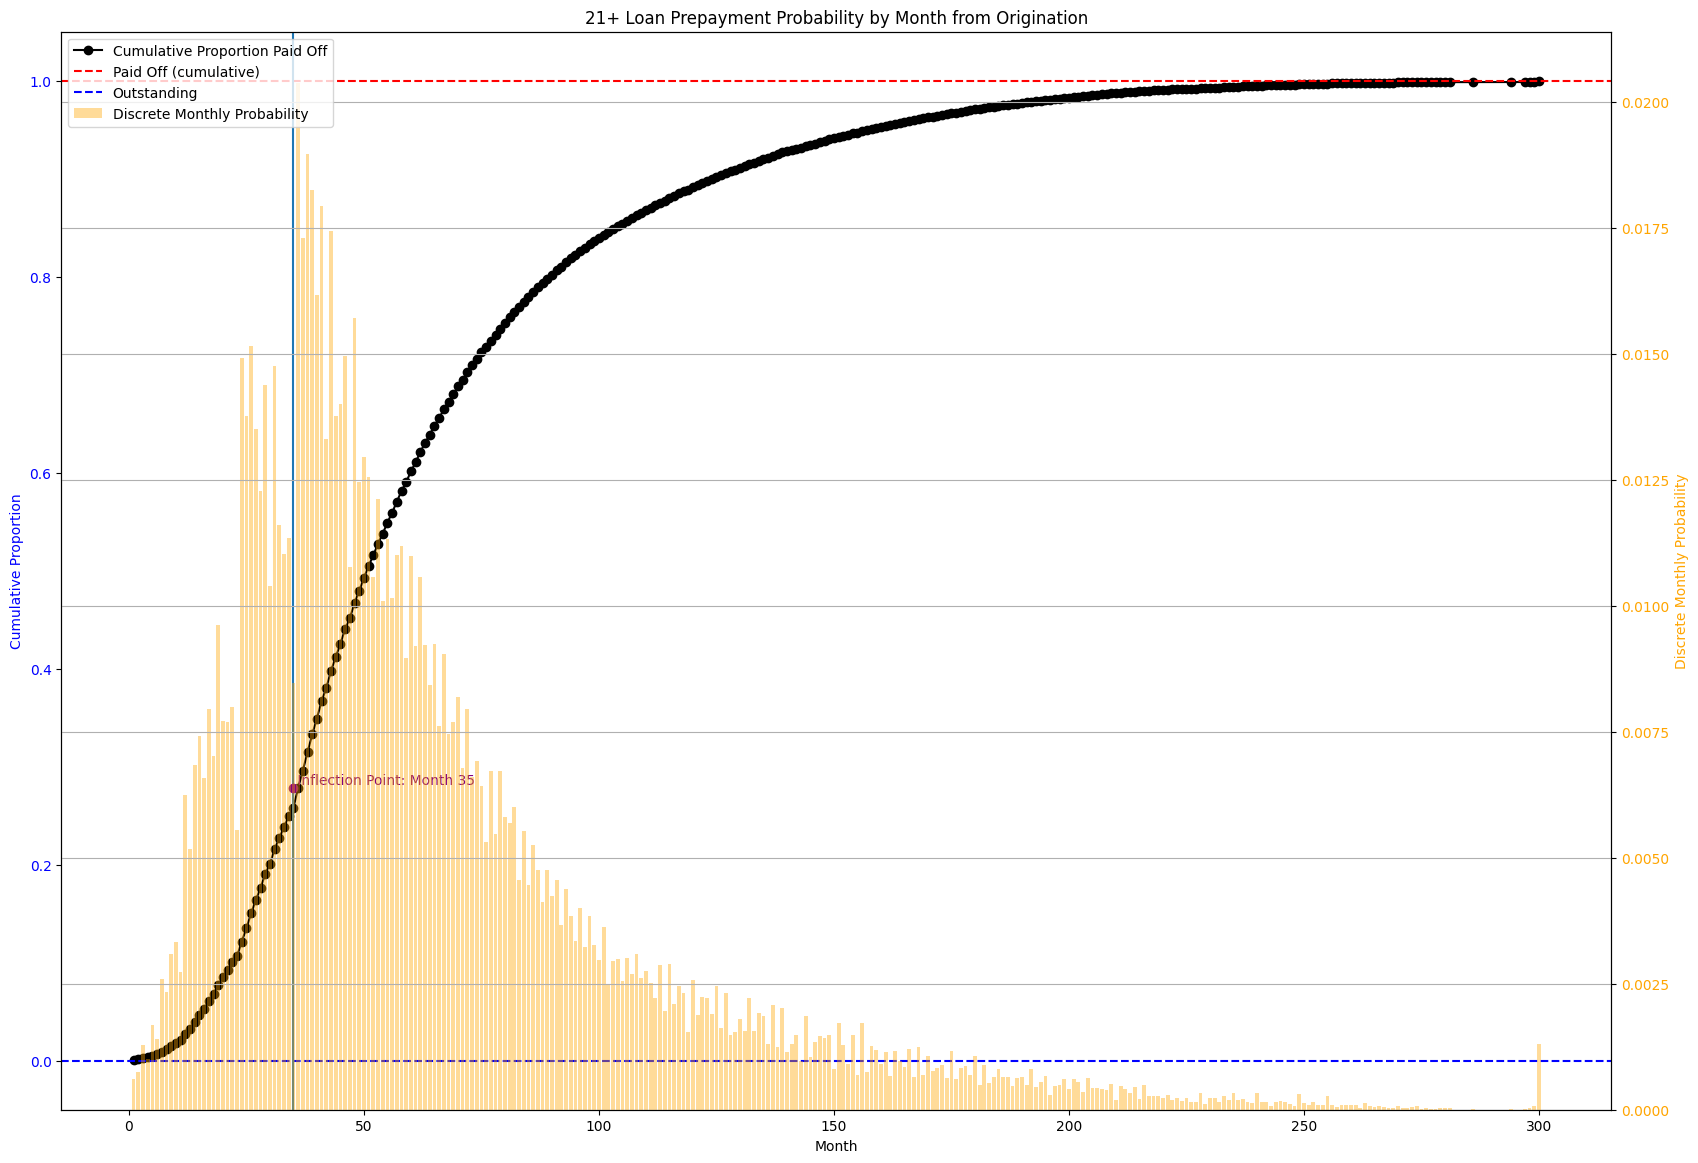

In [28]:
import matplotlib.pyplot as plt
import pandas as pd


# Calculate the first derivative (approximate slope between each point)
first_derivative = np.diff(cumulative_proportion.values) / np.diff(cumulative_proportion.index)


# Calculate the second derivative (change in slope between each point)
second_derivative = np.diff(first_derivative)

# Find the inflection point (maximum of the second derivative)
# Adding 1 because np.diff reduces the length of the array by 1
inflection_point_index = np.argmax(second_derivative) + 1
inflection_point_month = cumulative_proportion.index[inflection_point_index]
inflection_point_value = cumulative_proportion.iloc[inflection_point_index]

# Calculate the discrete monthly probabilities
discrete_probabilities = cumulative_proportion.diff().fillna(cumulative_proportion.iloc[0])

# Assuming cumulative_proportion is a pandas Series with the cumulative proportion of loans paid off by month
# Calculate the discrete monthly probabilities
discrete_probabilities = cumulative_proportion.diff().fillna(cumulative_proportion.iloc[0])

# Plotting the cumulative proportion
fig, ax1 = plt.subplots(figsize=(20, 14))

# Adding the cumulative proportion as a line plot on the primary y-axis
ax1.plot(cumulative_proportion.index, cumulative_proportion.values, label='Cumulative Proportion Paid Off', marker='o', color='black')
ax1.axhline(y=1, color='r', linestyle='--', label='Paid Off (cumulative)')
ax1.axhline(y=0, color='b', linestyle='--', label='Outstanding')


# Setting the labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Cumulative Proportion', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('21+ Loan Prepayment Probability by Month from Origination')

# Add inflection point if you have it calculated (replace 'inflection_point_month' with the actual month value)
ax1.axvline(x=inflection_point_month)
inflection_point_value = cumulative_proportion.iloc[inflection_point_month]
ax1.scatter(inflection_point_month, inflection_point_value, color='purple', zorder=5)
ax1.text(inflection_point_month, inflection_point_value, f' Inflection Point: Month {inflection_point_month}', color='purple', va='bottom')

# Create a secondary y-axis for the discrete monthly probabilities
ax2 = ax1.twinx()
ax2.bar(discrete_probabilities.index, discrete_probabilities.values, label='Discrete Monthly Probability', alpha=0.4, color='orange')
ax2.set_ylabel('Discrete Monthly Probability', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding a legend that combines both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()
